
📊 BÁO CÁO THỐNG KÊ DỮ LIỆU (1434 mẫu)
NHÃN (LABEL)    | SỐ LƯỢNG   | TỶ LỆ %   
----------------------------------------
ANG             | 230        | 16.0%
ANX             | 178        | 12.4%
HAP             | 167        | 11.6%
NEU             | 716        | 49.9%
SAD             | 143        | 10.0%
----------------------------------------


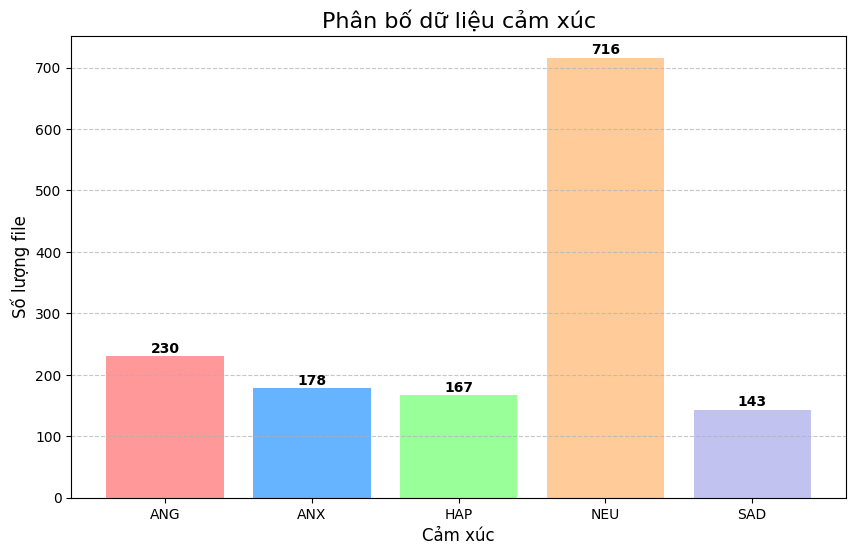

 Đã vẽ biểu đồ phân bố.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ===== CẤU HÌNH =====
project_root = os.path.dirname(os.getcwd())
preproc_dir = os.path.join(project_root, "pre_processing")
X_path = os.path.join(preproc_dir, "X_data.npy")
y_path = os.path.join(preproc_dir, "y_data.npy")

# ===== XỬ LÝ =====


# 1. Load dữ liệu
y_onehot = np.load(y_path)
classes = np.load(os.path.join(preproc_dir, "classes.npy"))

# 2. Giải mã One-hot về dạng số nguyên (Index)
# Ví dụ: [0, 0, 1, 0, 0] -> Index 2
y_indices = np.argmax(y_onehot, axis=1)

# 3. Đếm số lượng
unique, counts = np.unique(y_indices, return_counts=True)
stats = dict(zip(unique, counts))

total_samples = len(y_indices)

# ===== IN KẾT QUẢ =====
print("\n" + "="*40)
print(f"📊 BÁO CÁO THỐNG KÊ DỮ LIỆU ({total_samples} mẫu)")
print("="*40)
print(f"{'NHÃN (LABEL)':<15} | {'SỐ LƯỢNG':<10} | {'TỶ LỆ %':<10}")
print("-" * 40)

counts_list = [] # Để vẽ biểu đồ

for i, class_name in enumerate(classes):
    count = stats.get(i, 0) # Lấy số lượng, nếu không có thì bằng 0
    percent = (count / total_samples) * 100
    counts_list.append(count)
    
    print(f"{class_name:<15} | {count:<10} | {percent:.1f}%")

print("-" * 40)

# ===== VẼ BIỂU ĐỒ (Nếu chạy trên máy tính có màn hình) =====
try:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, counts_list, color=['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0'])
    
    # Viết số lên đầu cột
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontweight='bold')

    plt.title('Phân bố dữ liệu cảm xúc', fontsize=16)
    plt.xlabel('Cảm xúc', fontsize=12)
    plt.ylabel('Số lượng file', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    print(" Đã vẽ biểu đồ phân bố.")
except Exception as e:
    print(" Không thể vẽ biểu đồ (có thể do môi trường dòng lệnh).")